# Proyecto Text Mining: Estadísticas partido de fútbol

* Silvio Urizar 23008607
* Roberto Aldana 19000785

## Descripción del proyecto

El proyecto consiste en tomar una narración textual de un partido de fútbol por internet, y obtener las estadísticas aproximadas del mismo. Para esto, se toma una crónica escrita de marca.com, y se guarda en un archivo de texto. Dicho archivo es cargado al programa. Este limpia el archivo y genera una trama de strings que tienen los eventos más destacados y el minuto que ocurren.

Luego de generada la trama, se obtiene qué equipo es quien hace la acción destacada, ya sea: gol, falta, tiro de esquina, tarjeta amarilla, tarjeta roja, etc. Y se cuentan las acciones de cada equipo para desarrollar la estadística del encuentro. Además, se genera un wordcloud que presenta los datos más repetidos y relevantes del partido.

## Desarrollo

### Carga de librerías

In [ ]:
### importando librerías

import numpy as np
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Lectura de archivo

In [ ]:
### Función de lectura
def read_file(path):
    texto = []
    with open(path,'r') as f:
        linea = f.readlines()
        texto.extend(linea)
    return texto

In [ ]:
path = '/content/NarracionTest.txt'
Narra = read_file(path)

In [ ]:
Narra

['FULL TIME: Inter 1-0 (3-0) Milan\n',
 'Inter are through to the Champions League final! A second half goal from Lautaro Martinez sealed their trip to Istanbul, and they will now face Real Madrid or Man City in the final.\n',
 '\n',
 'Compartir en Twitter\n',
 '92\n',
 'Corner, AC Milan. Conceded by Francesco Acerbi.\n',
 '\n',
 'Compartir en Twitter\n',
 '91\n',
 'Bastoni volleys over\n',
 "Lukaku tests Maignan with a shot inside the box before the rebound is volleyed over the bar by Bastoni. It's all irrelevant now though, as Inter are cruising into the final.\n",
 '\n',
 'Compartir en Twitter\n',
 '90\n',
 'Foul by Theo Hernández (AC Milan).\n',
 '\n',
 'Compartir en Twitter\n',
 '90\n',
 'Denzel Dumfries (Inter Milan) wins a free kick in the defensive half.\n',
 '\n',
 'Compartir en Twitter\n',
 '88\n',
 'Pierre Kalulu (AC Milan) wins a free kick in the defensive half.\n',
 '\n',
 'Compartir en Twitter\n',
 '88\n',
 'Foul by Roberto Gagliardini (Inter Milan).\n',
 '\n',
 'Comparti

### Limpieza de archivo


Se observa que la string 'Compartir en Twitter' se repite a lo largo de todo el archivo, por lo que se suprime.

In [ ]:
def Data_clean(text):
  NarraCleanx = []
  for line in text:
    lineTemp = line.lower()
    if lineTemp != 'compartir en twitter\n':
      lineTemp = lineTemp.replace('\n','')
      if lineTemp != '':
        NarraCleanx.append(lineTemp)
  return NarraCleanx


Arreglado esto, se generan las strings de acciones minuto a minuto.

In [ ]:
def Data_time(trama):
  NarraWTimex = []
  for i in range(len(trama)):
    if(re.search(r'^[0-9]+$',trama[i])):
      temp = trama[i] + ':' + trama[i+1]
      NarraWTimex.append(temp)
  NarraWTimex = NarraWTimex[::-1]
  return NarraWTimex

Acto seguido, se recorre el bloque de strings generado para obtener los equipos que se están enfrentando, y cuál de los dos es el que genera la acción de interés. Esto se guarda en un data frame para su posterior análisis

In [ ]:
### Obtener equipos
def Get_Teams(text):
  teams = []
  for i in range(len(text)):
    team = re.findall(r'\(.*?\)', text[i])
    #print(len(team))
    if len(team) > 0:
      team[0] = team[0].replace('(','')
      team[0] = team[0].replace(')','')
      teams.append(team[0])
    else:
      teams.append('NA')
  UTeams = set(teams)
  fTeams = []
  for i in UTeams:
    if i != 'NA':
      fTeams.append(i)

  return fTeams

In [ ]:
def Action_Team(text,fTeams):
  #print(text)
  teamsa = np.zeros_like(text)
  for i in range(len(text)):
    if fTeams[0] in text[i]:
      teamsa[i] = fTeams[0]
    if fTeams[1] in text[i]:
      teamsa[i] = fTeams[1]
  return teamsa

In [ ]:
def Get_Jugadas(texto):
  stop_words = set(stopwords.words('english'))
  minutos = []
  jugadas = []
  Equipos = Get_Teams(texto)
  #print(Equipos)
  for line in texto:
    datos = line.split(':')
    minuto = datos[0]
    minutos.append(minuto)
    jugada = datos[1]
    jugada = jugada.replace('(','')
    jugada = jugada.replace(')','')
    jugada = re.sub(r'[^\w\s]', '', jugada)
    jugada = re.sub(r'\d','',jugada)
    string = Equipos[0] + '  ' + Equipos[1] + ' '
    #print(string)
    string2 = Equipos[1] + '  ' + Equipos[0] + ' '
    #print(string2)
    jugada = jugada.replace(string,'')
    jugada = jugada.replace(string2,'')
    #print(jugada)
    jugadaWords = jugada.split()
    JugadaFiltrada = [palabra for palabra in jugadaWords if palabra not in stop_words]
    jugada = ' '.join(JugadaFiltrada)
    jugadas.append(jugada)
  teams = Action_Team(jugadas,Equipos)
  cuadro = {
      'minuto' : minutos,
      'jugada' : jugadas,
      'Equipo' : teams
  }
  cuadro = pd.DataFrame(cuadro)
  return cuadro, Equipos

### Generación de estadísticas

Se genera una función que extrae las estadísticas del juego al revisar el dataframe ya con el formato requerido

In [ ]:
def Statistics(Data,teams):
  Team1 = teams[0]
  Team2 = teams[1]
  jugadas = Data['jugada']
  vars = ['Goles','Tiros','Corners','Faltas','Tarjetas Amarillas', 'Tarjetas Rojas', 'Offsides','Cambios']
  flags = ['goal','attempt','corner','foul','yellow','red','offside','substitution']
  StatsTeam1 = np.zeros(len(vars))
  #print(StatsTeam1)
  StatsTeam2 = np.zeros(len(vars))
  #print(StatsTeam2)
  for jugada in jugadas:
    jug = jugada.split()
    for i in range(len(flags)):
      if flags[i] in jug[0]:
        if Team1 in jugada:
          StatsTeam1[i] = StatsTeam1[i] + 1
        if Team2 in jugada:
          StatsTeam2[i] = StatsTeam2[i] + 1
  Stats = {
      'Stat' : vars,
      Team1 : StatsTeam1,
      Team2 : StatsTeam2
      }
  Stats = pd.DataFrame(Stats)
  return Stats



### Generación de wordcloud

Para generar el wordcloud, primero se tokeniza la información de la crónica textual limpia. Al mismo tiempo, estos tokens se stemizan y se lematizan para verificar qué técnica favorece a la detección de información en las palabras.

In [ ]:
def tokens(Data):
  jugadas = Data['jugada']
  tokensjuego = []
  stemjuego = []
  lemjuego = []
  stem = PorterStemmer()
  lem = WordNetLemmatizer()
  for jugada in jugadas:
    tk = jugada.split()
    for word in tk:
      stemword = stem.stem(word)
      stemjuego.append(stemword)
      lemjuego.append(lem.lemmatize(word))
    tokensjuego.extend(tk)
  toks = {
      'tokens' : tokensjuego,
      'stems' : stemjuego,
      'lemmas' : lemjuego
  }
  toks = pd.DataFrame(toks)
  return toks

Luego de tener los tokens deseados, se genera el wordcloud

In [ ]:
def WC(Data):
  palabras = ''
  palabras += " ".join(Data)+" "
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(palabras)
  # plot the WordCloud image
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

## Pruebas

### Partido 1

In [ ]:
NarraClean = Data_clean(Narra)

In [ ]:
NarraClean

['full time: inter 1-0 (3-0) milan',
 'inter are through to the champions league final! a second half goal from lautaro martinez sealed their trip to istanbul, and they will now face real madrid or man city in the final.',
 '92',
 'corner, ac milan. conceded by francesco acerbi.',
 '91',
 'bastoni volleys over',
 "lukaku tests maignan with a shot inside the box before the rebound is volleyed over the bar by bastoni. it's all irrelevant now though, as inter are cruising into the final.",
 '90',
 'foul by theo hernández (ac milan).',
 '90',
 'denzel dumfries (inter milan) wins a free kick in the defensive half.',
 '88',
 'pierre kalulu (ac milan) wins a free kick in the defensive half.',
 '88',
 'foul by roberto gagliardini (inter milan).',
 '87',
 'foul by alexis saelemaekers (ac milan).',
 '87',
 'hakan çalhanoglu (inter milan) wins a free kick in the defensive half.',
 '86',
 'foul by joaquín correa (inter milan).',
 '86',
 'sandro tonali (ac milan) wins a free kick in the attacking h

In [ ]:
NarraWTime = Data_time(NarraClean)

In [ ]:
NarraWTime

['0:first half begins.',
 '0:theo hernández (ac milan) wins a free kick in the defensive half.',
 '0:foul by edin dzeko (inter milan).',
 '0:foul by brahim díaz (ac milan).',
 '0:hakan çalhanoglu (inter milan) wins a free kick in the attacking half.',
 '1:theo hernández (ac milan) wins a free kick in the defensive half.',
 '1:foul by denzel dumfries (inter milan).',
 '2:sandro tonali (ac milan) wins a free kick in the defensive half.',
 '2:foul by nicolò barella (inter milan).',
 '3:brahim díaz (ac milan) wins a free kick on the right wing.',
 '3:foul by hakan çalhanoglu (inter milan).',
 '4:theo fires a warning!',
 '5:foul by rafael leão (ac milan).',
 '5:denzel dumfries (inter milan) wins a free kick on the right wing.',
 '6:attempt missed. nicolò barella (inter milan) right footed shot from outside the box is too high. assisted by henrikh mkhitaryan.',
 '9:corner, ac milan. conceded by matteo darmian.',
 '10:onana with a crucial save!',
 '11:delay in match because of an injury nicol

In [ ]:
### obtener jugadas y qué equipos juegan

Data, Equipos = Get_Jugadas(NarraWTime)

In [ ]:
print(Equipos)

['inter milan', 'ac milan']


In [ ]:
Data

,minuto,jugada,Equipo
0,0,first half begins,
1,0,theo hernández ac milan wins free kick defensi...,ac milan
2,0,foul edin dzeko inter milan,inter milan
3,0,foul brahim díaz ac milan,ac milan
4,0,hakan çalhanoglu inter milan wins free kick at...,inter milan
...,...,...,...
124,88,pierre kalulu ac milan wins free kick defensiv...,ac milan
125,90,denzel dumfries inter milan wins free kick def...,inter milan
126,90,foul theo hernández ac milan,ac milan
127,91,bastoni volleys,


In [ ]:
Statistics(Data,Equipos)

,Stat,inter milan,ac milan
0,Goles,1.0,0.0
1,Tiros,12.0,2.0
2,Corners,5.0,3.0
3,Faltas,15.0,20.0
4,Tarjetas Amarillas,0.0,0.0
5,Tarjetas Rojas,0.0,0.0
6,Offsides,1.0,0.0
7,Cambios,5.0,3.0


In [ ]:
## Generación de tokens
tks = tokens(Data)

In [ ]:
tks.sample(20)

,tokens,stems,lemmas
227,francesco,francesco,francesco
81,denzel,denzel,denzel
739,olivier,olivi,olivier
630,ac,ac,ac
889,joaquín,joaquín,joaquín
734,replaces,replac,replaces
795,milan,milan,milan
158,tonali,tonali,tonali
774,mike,mike,mike
30,half,half,half


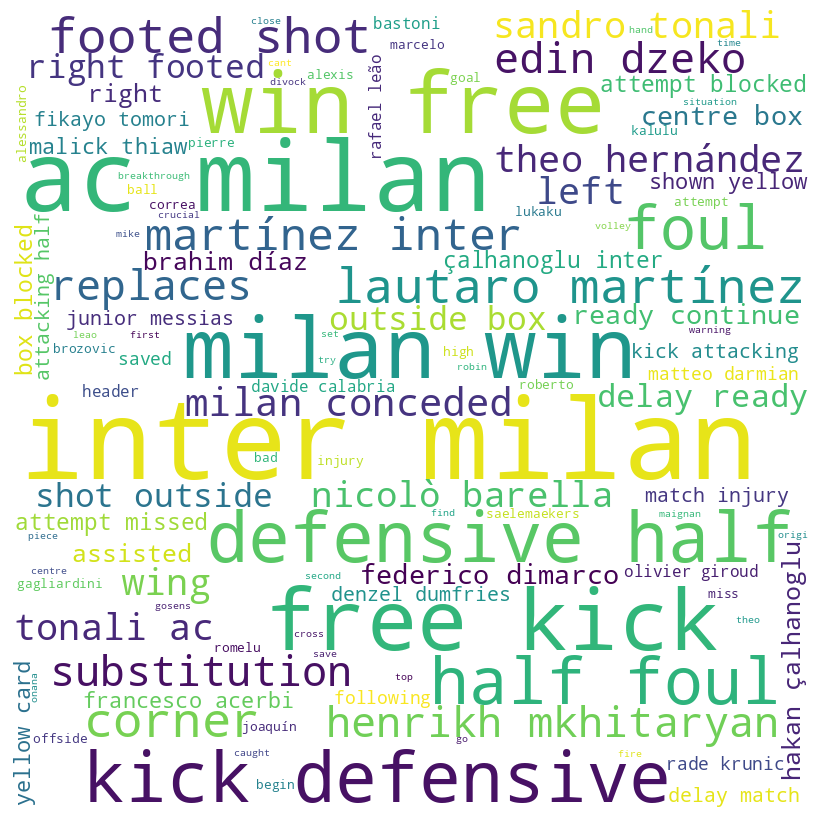

In [ ]:
WC(tks['lemmas'])

### Partido 2

In [ ]:
path2 = '/content/test2.txt'
RB = read_file(path2)

In [ ]:
RB

['Match ends, Real Betis 1, Cadiz 1.\n',
 '\n',
 'Compartir en Twitter\n',
 '97\n',
 'Second Half ends, Real Betis 1, Cadiz 1.\n',
 '\n',
 'Compartir en Twitter\n',
 '96\n',
 'Offside, Real Betis. Isco tries a through ball, but Guido Rodríguez is caught offside.\n',
 '\n',
 'Compartir en Twitter\n',
 '96\n',
 'Attempt missed. Isco (Real Betis) header from the centre of the box misses to the left. Assisted by Andrés Guardado with a cross following a corner.\n',
 '\n',
 'Compartir en Twitter\n',
 '96\n',
 'Corner, Real Betis. Conceded by Luis Hernández.\n',
 '\n',
 'Compartir en Twitter\n',
 '95\n',
 'Rubén Sobrino (Cadiz) is shown the yellow card for a bad foul.\n',
 '\n',
 'Compartir en Twitter\n',
 '95\n',
 'Isco (Real Betis) is shown the yellow card.\n',
 '\n',
 'Compartir en Twitter\n',
 '95\n',
 'Isco (Real Betis) wins a free kick in the defensive half.\n',
 '\n',
 'Compartir en Twitter\n',
 '95\n',
 'Foul by Rubén Sobrino (Cadiz).\n',
 '\n',
 'Compartir en Twitter\n',
 '94\n',
 'F

In [ ]:
RBClean = Data_clean(RB)
RBClean

['match ends, real betis 1, cadiz 1.',
 '97',
 'second half ends, real betis 1, cadiz 1.',
 '96',
 'offside, real betis. isco tries a through ball, but guido rodríguez is caught offside.',
 '96',
 'attempt missed. isco (real betis) header from the centre of the box misses to the left. assisted by andrés guardado with a cross following a corner.',
 '96',
 'corner, real betis. conceded by luis hernández.',
 '95',
 'rubén sobrino (cadiz) is shown the yellow card for a bad foul.',
 '95',
 'isco (real betis) is shown the yellow card.',
 '95',
 'isco (real betis) wins a free kick in the defensive half.',
 '95',
 'foul by rubén sobrino (cadiz).',
 '94',
 'foul by andrés guardado (real betis).',
 '94',
 'iza carcelén (cadiz) wins a free kick in the defensive half.',
 '93',
 'corner, real betis. conceded by jeremías ledesma.',
 '93',
 'attempt saved. ayoze pérez (real betis) header from the centre of the box is saved in the top left corner. assisted by luiz henrique with a cross.',
 '92',
 'att

In [ ]:
RBTime = Data_time(RBClean)
RBTime

['0:first half begins.',
 '0:offside, cadiz. maximiliano gómez tries a through ball, but iván alejo is caught offside.',
 '2:hand ball by rubén alcaraz (cadiz).',
 '3:foul by ayoze pérez (real betis).',
 '3:iván alejo (cadiz) wins a free kick in the defensive half.',
 '4:foul by willian josé (real betis).',
 '4:jorge meré (cadiz) wins a free kick in the defensive half.',
 '4:delay in match because of an injury jeremías ledesma (cadiz).',
 '6:delay over. they are ready to continue.',
 '9:foul by iza carcelén (cadiz).',
 '9:ayoze pérez (real betis) wins a free kick in the defensive half.',
 '11:attempt missed. rodri (real betis) right footed shot from a difficult angle on the right is high and wide to the right. assisted by willian josé.',
 '15:offside, cadiz. rubén alcaraz tries a through ball, but maximiliano gómez is caught offside.',
 '18:corner, real betis. conceded by gonzalo escalante.',
 '19:fali (cadiz) wins a free kick in the defensive half.',
 '19:foul by willian josé (real be

In [ ]:
DataBetis, Equipos01 = Get_Jugadas(RBTime)

In [ ]:
DataBetis

,minuto,jugada,Equipo
0,0,first half begins,
1,0,offside cadiz maximiliano gómez tries ball ivá...,cadiz
2,2,hand ball rubén alcaraz cadiz,cadiz
3,3,foul ayoze pérez real betis,real betis
4,3,iván alejo cadiz wins free kick defensive half,cadiz
...,...,...,...
120,95,rubén sobrino cadiz shown yellow card bad foul,cadiz
121,96,corner real betis conceded luis hernández,real betis
122,96,attempt missed isco real betis header centre b...,real betis
123,96,offside real betis isco tries ball guido rodrí...,real betis


In [ ]:
Statistics(DataBetis,Equipos01)

,Stat,real betis,cadiz
0,Goles,1.0,1.0
1,Tiros,20.0,4.0
2,Corners,11.0,8.0
3,Faltas,10.0,13.0
4,Tarjetas Amarillas,0.0,0.0
5,Tarjetas Rojas,0.0,0.0
6,Offsides,1.0,5.0
7,Cambios,5.0,5.0


In [ ]:
tksBetis = tokens(DataBetis)

In [ ]:
tksBetis

,tokens,stems,lemmas
0,first,first,first
1,half,half,half
2,begins,begin,begin
3,offside,offsid,offside
4,cadiz,cadiz,cadiz
...,...,...,...
1011,caught,caught,caught
1012,offside,offsid,offside
1013,second,second,second
1014,half,half,half


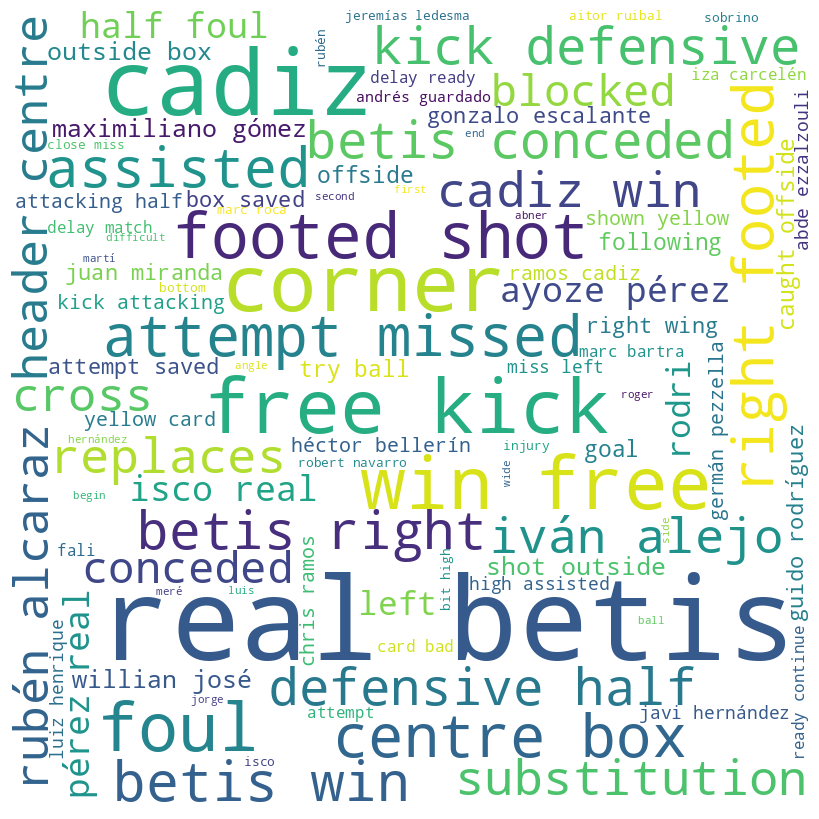

In [ ]:
WC(tksBetis['lemmas'])